In [3]:
"""
Solve Ax = b using cuSolver (LU decomposition)
"""

# numpy/init part
import numpy as np
import matplotlib.pyplot as plt
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
np.set_printoptions(formatter={'float': '{: .3f}'.format})

N = 8192  # size
R = 64    # nrhs
run_numpy = True

# https://cscproxy.mpi-magdeburg.mpg.de/mpcsc/lehre/2016_WS_SC/handouts/handout_LU_counting.pdf
getrf_gflop = 1e-9 * ((2/3)* N**3 - (1/2)* N**2) # approximately
getrs_gflop = 1e-9 * (R * (N**2 - N)) # more/less proporional to R
total_gflop = getrs_gflop + getrf_gflop

A = np.random.randn(N, N).astype(np.float64, order='F')
b = np.random.randn(N, R).astype(np.float64, order='F')

# just to confirm
print(f'{A.shape=} {b.shape=}')
print(f'{N=}, {R=}, {getrf_gflop=:5.3f}, {getrs_gflop=:5.3f}')
print('')

if run_numpy:
    
    t0 = time()
    x = np.linalg.solve(A, b).astype(np.float64)
    t_numpy = (time() - t0)

    err = np.linalg.norm(np.dot(A, x) - b)
    print(f'numpy err  = {err:g}\n'
          f'numpy time = {1e3 * t_numpy:.4f} ms, {total_gflop/t_numpy:.4f} GF/s')
else:
    # just a placeholder
    x = np.zeros((N, R)).astype(np.float64, order='F')
    t_numpy = np.inf
    err = np.inf

A.shape=(8192, 8192) b.shape=(8192, 64)
N=8192, R=64, getrf_gflop=366.470, getrs_gflop=4.294

numpy err  = 7.70591e-09
numpy time = 5260.0043 ms, 70.4875 GF/s


In [4]:
# GPU
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import pycuda.driver as drv

import skcuda.cublas as cublas
import skcuda.cusolver as cusolver

def lu_cusolver(handle, A, b):
        
    d_A = gpuarray.to_gpu(A)
    d_b = gpuarray.to_gpu(b)

    d_info = gpuarray.zeros(1, np.int32)
    d_ipiv = gpuarray.zeros((N, ), np.int32)

    worksize = cusolver.cusolverDnDgetrf_bufferSize(handle, N, N, d_A.ptr, 0)
    scratchpad = gpuarray.empty(worksize, np.float64)

    start_getrf = drv.Event()
    end_getrf   = drv.Event()

    # cusolverDnDgetrf(
    # handle, m, n, a, lda, workspace, devIpiv, devInfo)
    start_getrf.record()

    lu_status = cusolver.cusolverDnDgetrf(
        handle=handle,
        m=N,
        n=N,
        a=d_A.ptr,
        lda=N,
        workspace=scratchpad.ptr,
        devIpiv=d_ipiv.ptr,
        devInfo=d_info.ptr
    )

    end_getrf.record()
    end_getrf.synchronize()
    getrf_time = end_getrf.time_since(start_getrf) / 1e3
    
    if d_info.get()[0] != 0:
        print(f'! err: {d_info}')

    # show the left top corner for debug
    #fig = plt.matshow(d_A.get()[:64,:64])

    start_getrs = drv.Event()
    end_getrs   = drv.Event()

    start_getrs.record()

    # cusolverDnDgetrs(
    # handle, trans, n, nrhs, a, lda, devIpiv, B, ldb, devInfo)

    solve_status = cusolver.cusolverDnDgetrs(
        handle=handle,
        trans=0,
        n=N,
        nrhs=R,
        a=d_A.ptr,
        lda=N,
        devIpiv=d_ipiv.ptr,
        B=d_b.ptr,
        ldb=N,
        devInfo=d_info.ptr
    )

    end_getrs.record()
    end_getrs.synchronize()
    getrs_time = end_getrs.time_since(start_getrs) / 1e3
    
    if d_info.get()[0] != 0:
        print(f'! err: {d_info}')
    
    x_cuda = d_b.get()

    return x_cuda, getrf_time, getrs_time 

pycuda.VERSION_TEXT='2021.1'
drv.get_version()=(11, 5, 0)
drv.get_driver_version()=11050
5 device(s) found.

Using device 1 (NVIDIA A100-SXM-80GB)
108 SMs, 2039 GBps, 40.0 MB L2

cusolverDnDgetrf time = 0.0988 ms, 3709.1813 GF/s
cusolverDnDgetrs time = 0.0086 ms, 498.6729 GF/s
cusolver err          = 2.32578e-08



Text(0.5, 1.0, 'solution cusolver')

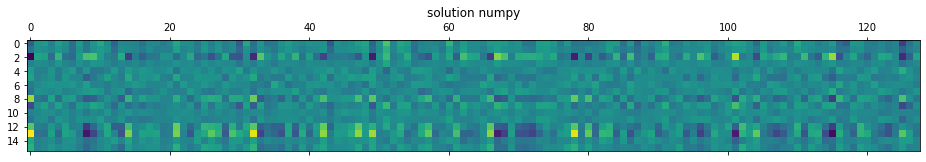

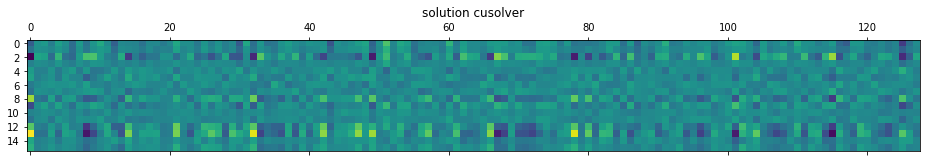

In [5]:
print(f'{pycuda.VERSION_TEXT=}')
print(f'{drv.get_version()=}')
print(f'{drv.get_driver_version()=}')

print("%d device(s) found." % drv.Device.count())
print()

# select device
dev_id = 1
ctx = drv.Device(dev_id).make_context()
dev = drv.Context.get_device()
free_bytes, total_bytes = drv.mem_get_info()
print(f'Using device {dev_id} ({dev.name()})')

attributes = drv.Context.get_device().get_attributes()
sms = attributes[drv.device_attribute.MULTIPROCESSOR_COUNT]
mcr = attributes[drv.device_attribute.MEMORY_CLOCK_RATE]
bus = attributes[drv.device_attribute.GLOBAL_MEMORY_BUS_WIDTH]
l2s = attributes[drv.device_attribute.L2_CACHE_SIZE]

print(f"{sms} SMs, {mcr*1000*bus*2*1e-9/8:.0f} GBps, {l2s/1024**2:.1f} MB L2\n")

handle = cusolver.cusolverDnCreate()

# LU using cuSolver
x_cuda, getrf_time, getrs_time = lu_cusolver(handle, A, b)

# check solution(s)
err_cusolver = np.linalg.norm(np.dot(A, x_cuda) - b)
status = cusolver.cusolverDnDestroy(handle)

print(f'cusolverDnDgetrf time = {getrf_time:.4f} ms, {getrf_gflop/getrf_time:.4f} GF/s\n'
      f'cusolverDnDgetrs time = {getrs_time:.4f} ms, {getrs_gflop/getrs_time:.4f} GF/s\n'
      f'cusolver err          = {err_cusolver:g}\n')

# show the top left corners for debug
plt.matshow(x[:128,:16].T)
plt.title('solution numpy')
plt.matshow(x_cuda[:128,:16].T)
plt.title('solution cusolver')